In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [13]:
import numpy as np

In [107]:
original = fetch_lfw_people(min_faces_per_person=70, resize=0.5)
original.images.shape

(1288, 62, 47)

In [17]:
#print(np.min(X[0,:]), np.mean(X[0,:]), np.max(X[0,:]) )

17.0 129.48387 254.33333


In [18]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [27]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [90]:
picture_0 = lfw_people.images[0,:,:]
picture_0

array([[254.      , 254.      , 251.66667 , ...,  65.333336,  50.666668,
         40.333332],
       [253.33333 , 251.33333 , 247.33333 , ...,  66.666664,  52.      ,
         42.666668],
       [240.66667 , 231.66667 , 211.66667 , ...,  62.      ,  49.      ,
         42.      ],
       ...,
       [ 74.333336,  54.      ,  31.666666, ...,  97.666664,  93.      ,
         90.      ],
       [ 65.333336,  47.      ,  30.333334, ...,  91.666664,  92.      ,
         86.333336],
       [ 59.333332,  44.333332,  32.333332, ...,  87.333336,  88.666664,
         86.666664]], dtype=float32)

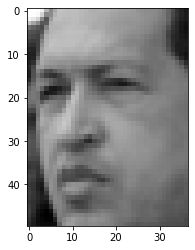

In [93]:
plt.imshow(picture_0, cmap = 'gray')

In [70]:
lfw_people.data.shape

(1288, 1850)

In [72]:
lfw_people.images.shape

(1288, 50, 37)

In [19]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

In [22]:
print(f"number of samples {n_samples}, image size {h}x{w}")

number of samples 1288, image size 50x37


In [23]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
print(X.shape, n_features)

(1288, 1850) 1850


In [24]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [25]:
y

array([5, 6, 3, ..., 5, 3, 5], dtype=int64)

In [30]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [31]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


In [32]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [33]:
print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")

Extracting the top 150 eigenfaces from 966 faces


In [37]:
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print(f"done in {time() - t0}")

done in 1.448387622833252


In [39]:
pca.components_.shape

(150, 1850)

In [41]:
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenfaces.shape

(150, 50, 37)

In [42]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"done in {(time() - t0)}")

Projecting the input data on the eigenfaces orthonormal basis
done in 0.030918598175048828


In [43]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print(f"done in {(time() - t0)}")
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 48.87730884552002
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [44]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print(f"done in {(time() - t0)}")

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.08480429649353027
                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.54      0.61        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.95      0.67      0.78        27
    George W Bush       0.85      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.86       322
        macro avg       0.89      0.74      0.79       322
     weighted avg       0.87      0.86      0.85       322

[[  7   2   0   4   0   0   0]
 [  2  52   0   6   0   0   0]
 [  1   2  18   6   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   2   1   8   0]
 [  0   2   1   5   0   0  28]]


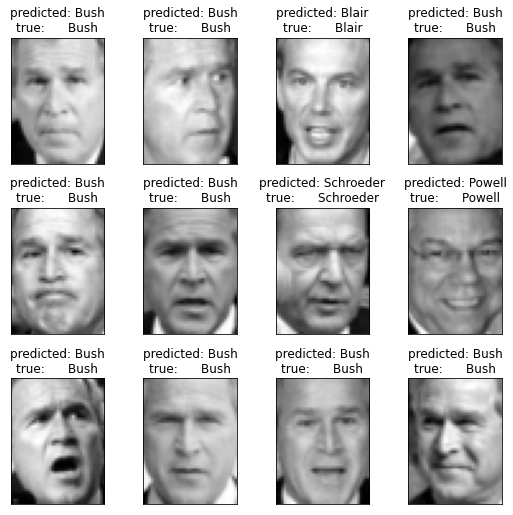

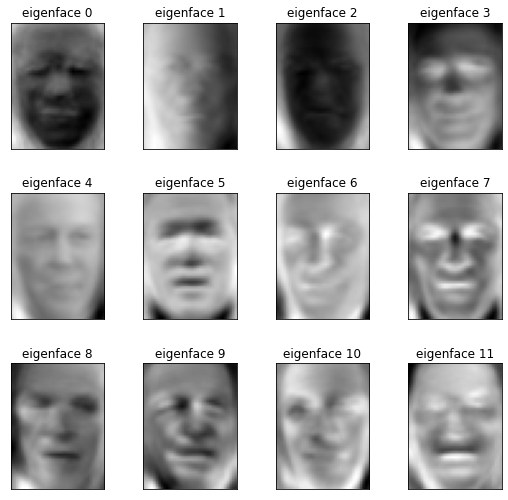

In [45]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [73]:
target_names[y_pred[5]].rsplit(' ', 1)

['George W', 'Bush']

In [88]:
target_names[y_pred[5]].rsplit(' ', 1)

['George W', 'Bush']

In [102]:
pca.components_.shape

(150, 1850)

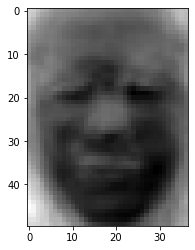

In [103]:
_ = pca.components_[0,:].reshape(50,37)
plt.imshow(_, cmap = 'gray')

In [97]:
lfw_people.images.shape

(1288, 50, 37)

#### Components_ of PCA are eigenfaces